In [2]:
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.types import Send
from langgraph.graph import StateGraph
from langgraph.graph import START, END
from langchain_core.runnables import RunnableConfig
from llm import ollama_model, watsonx_model
from state import (
    OverallState,
    QueryGenerationState,
    ReflectionState,
    WebSearchState,
)
from configuration import Configuration
llm = ollama_model

In [3]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///./database/app.db")

print(f"Dialect: {db.dialect}")
print(f"Available tables: {db.get_usable_table_names()}")
print(f'Sample output: {db.run("SELECT * FROM users LIMIT 5;")}')

Dialect: sqlite
Available tables: ['service_tiers', 'services', 'subscriptions', 'transactions', 'users']
Sample output: [(1, 'alice@example.com', 'Alice', 'Smith', '1234567890'), (2, 'bob@example.com', 'Bob', 'Jones', '9876543210'), (3, 'carol@example.com', 'Carol', 'Taylor', '5551234567')]


In [4]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm)

tools = toolkit.get_tools()

for tool in tools:
    print(f"{tool.name}: {tool.description}\n")

sql_db_query: Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.

sql_db_schema: Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3

sql_db_list_tables: Input is an empty string, output is a comma-separated list of tables in the database.

sql_db_query_checker: Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!



In [5]:
from typing import Literal
from langchain_core.messages import AIMessage
from langchain_core.runnables import RunnableConfig
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode



get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")
get_schema_node = ToolNode([get_schema_tool], name="get_schema")

run_query_tool = next(tool for tool in tools if tool.name == "sql_db_query")
run_query_node = ToolNode([run_query_tool], name="run_query")


# Example: create a predetermined tool call
def list_tables(state: MessagesState):
    tool_call = {
        "name": "sql_db_list_tables",
        "args": {},
        "id": "abc123",
        "type": "tool_call",
    }
    tool_call_message = AIMessage(content="", tool_calls=[tool_call])

    list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
    tool_message = list_tables_tool.invoke(tool_call)
    response = AIMessage(f"Available tables: {tool_message.content}")

    return {"messages": [tool_call_message, tool_message, response]}


# Example: force a model to create a tool call
def call_get_schema(state: MessagesState):
    # Note that LangChain enforces that all models accept `tool_choice="any"`
    # as well as `tool_choice=<string name of tool>`.
    llm_with_tools = llm.bind_tools([get_schema_tool], tool_choice="auto")
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}





def generate_query(state: MessagesState):
    generate_query_system_prompt = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

{input_question}
""".format(
    dialect=db.dialect,
    top_k=5,
    input_question=state["messages"][-1].content,
)
    user_message = {
        "role": "user",
        "content": generate_query_system_prompt,
    }
    # We do not force a tool call here, to allow the model to
    # respond naturally when it obtains the solution.
    llm_with_tools = llm.bind_tools([run_query_tool])
    response = llm_with_tools.invoke([user_message])
    return {"messages": [response]}


check_query_system_prompt = """
You are a SQL expert with a strong attention to detail.
Double check the {dialect} query for common mistakes, including:
    - Using NOT IN with NULL values
    - Using UNION when UNION ALL should have been used
    - Using BETWEEN for exclusive ranges
    - Data type mismatch in predicates
    - Properly quoting identifiers
    - Using the correct number of arguments for functions
    - Casting to the correct data type
    - Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes,
just reproduce the original query.

You will call the appropriate tool to execute the query after running this check.
""".format(dialect=db.dialect)


def check_query(state: MessagesState):
    system_message = {
        "role": "system",
        "content": check_query_system_prompt,
    }

    # Generate an artificial user message to check
    tool_call = state["messages"][-1].tool_calls[0]
    user_message = {"role": "user", "content": tool_call["args"]["query"]}
    llm_with_tools = llm.bind_tools([run_query_tool], tool_choice="auto")
    response = llm_with_tools.invoke([system_message, user_message])
    response.id = state["messages"][-1].id
    return {"messages": [response]}

# State (The data that gets pass between nodes)

In [6]:
from __future__ import annotations

from dataclasses import dataclass, field
from typing import TypedDict

from langgraph.graph import add_messages
from typing_extensions import Annotated


import operator


class OverallState(TypedDict):
    messages: Annotated[list, add_messages]
    user_id: int 
    firstName: str
    lastName: str
    subscriptions: Annotated[list, operator.add]
    # search_query: Annotated[list, operator.add]
    # web_research_result: Annotated[list, operator.add]
    # sources_gathered: Annotated[list, operator.add]
    # initial_search_query_count: int
    # max_research_loops: int
    # research_loop_count: int
    # reasoning_model: str

# Get specific user's subscription information when recieve the User_ID and questions

In [27]:
from database.database import SessionLocal
from sqlalchemy import text
db = SessionLocal()
user_id = 2
out = db.execute(text(f"""SELECT 
    u.id as user_id,
    u.email,
    u.firstName,
    u.lastName,
    s.start_date as subscription_start,
    s.current_status as subscription_status,
    st.tier_name,
    st.price_usd,
    sv.name as service_name,
    sv.category
FROM users u
LEFT JOIN subscriptions s ON u.id = s.user_id
LEFT JOIN service_tiers st ON s.tier_id = st.id
LEFT JOIN services sv ON st.service_id = sv.id
WHERE u.id = {user_id};"""))

rows_as_dicts = [row._asdict() for row in out]

for row_dict in rows_as_dicts:
    print(row_dict)



{'user_id': 2, 'email': 'bob@example.com', 'firstName': 'Bob', 'lastName': 'Jones', 'subscription_start': '2023-01-11', 'subscription_status': 'cancelled', 'tier_name': 'Standard with Ads', 'price_usd': 6.99, 'service_name': 'Netflix', 'category': 'Streaming'}
{'user_id': 2, 'email': 'bob@example.com', 'firstName': 'Bob', 'lastName': 'Jones', 'subscription_start': '2023-06-10', 'subscription_status': 'trial', 'tier_name': 'Family', 'price_usd': 16.99, 'service_name': 'Apple Music', 'category': 'Music'}
{'user_id': 2, 'email': 'bob@example.com', 'firstName': 'Bob', 'lastName': 'Jones', 'subscription_start': '2023-05-01', 'subscription_status': 'active', 'tier_name': 'With Ads', 'price_usd': 9.99, 'service_name': 'HBO Max', 'category': 'Streaming'}


## Node Setup

In [10]:
from database.database import SessionLocal
from sqlalchemy import text


def get_user_subscription(state: OverallState):
    # configurable = Configuration.from_runnable_config(config)

    db = SessionLocal()
    user_id = state["user_id"]
    out = db.execute(text(f"""SELECT 
    s.start_date as subscription_start,
    s.current_status as subscription_status,
    st.tier_name,
    st.price_usd,
    sv.name as service_name,
    sv.category
    FROM users u
    LEFT JOIN subscriptions s ON u.id = s.user_id
    LEFT JOIN service_tiers st ON s.tier_id = st.id
    LEFT JOIN services sv ON st.service_id = sv.id
    WHERE u.id = {user_id};"""))

    subscriptions = []
    rows_as_dicts = [row._asdict() for row in out]
    for row_dict in rows_as_dicts:
        subscriptions.append(row_dict)

    out = db.execute(text(f"""SELECT 
    u.firstName,
    u.lastName
    FROM users u
    WHERE u.id = {user_id};"""))
    out = [row._asdict() for row in out]
    firstName = out[0]["firstName"]
    lastName = out[0]["lastName"]
    
    return {'subscriptions': subscriptions, "firstName": firstName, "lastName": lastName}


### Testing the Node

In [12]:
from langchain_core.messages import HumanMessage

test_state = {
    
    'messages': [
        HumanMessage(content="Test message")
    ],
    'user_id': 1
}
out = get_user_subscription(test_state)

print(out)


{'subscriptions': [{'subscription_start': '2023-01-08', 'subscription_status': 'cancelled', 'tier_name': 'Standard with Ads', 'price_usd': 6.99, 'service_name': 'Netflix', 'category': 'Streaming'}, {'subscription_start': '2023-04-01', 'subscription_status': 'active', 'tier_name': 'Monthly', 'price_usd': 14.99, 'service_name': 'Amazon Prime', 'category': 'Shopping'}, {'subscription_start': '2023-07-01', 'subscription_status': 'active', 'tier_name': 'All Apps', 'price_usd': 54.99, 'service_name': 'Adobe Creative Cloud', 'category': 'Productivity'}], 'firstName': 'Alice', 'lastName': 'Smith'}


### testing other joined tables

In [ ]:
from database.database import SessionLocal
from sqlalchemy import text
db = SessionLocal()
user_id = 1
out = db.execute(text(f"""SELECT 
    u.email,
    u.firstName,
    u.lastName,
    s.start_date,
    s.next_renewal_date,
    s.amount_billed,
    s.currency,
    st.tier_name,
    st.billing_period,
    sv.name as service_name,
    sv.website
FROM users u
LEFT JOIN subscriptions s ON u.id = s.user_id
LEFT JOIN service_tiers st ON s.tier_id = st.id
LEFT JOIN services sv ON st.service_id = sv.id
WHERE u.id = {user_id}
ORDER BY u.lastName, u.firstName;"""))


for row in out: 
    print(row)


# Prompt to allow Agent to view the user subscriptions

## Node Setup

In [13]:
from database.database import SessionLocal
from sqlalchemy import text


def agent_review_user_subscription(state: OverallState):
    # configurable = Configuration.from_runnable_config(config)
    firstName = state["firstName"]
    question = state["messages"][0].content
    subscription_history = state["subscriptions"]

    column = "service_name | category | tier_name | price_usd | subscription_start | subscription_status\n"
    format_subscription_history = column + "\n".join([f"{sub['service_name']} | {sub['category']} | {sub['tier_name']} | {sub['price_usd']} | {sub['subscription_start']} | {sub['subscription_status']}" for sub in subscription_history])
    # print(format_subscription_history)
    subscription_analysis_prompt = f"""
You are a helpful financial assistant. Your job is to analyze the user's subscription history and recommend ways to reduce their monthly spending.
Here is the user's subscription history:
    {format_subscription_history}

Based on the provided subscription data, do the following:
    1.	Usage Analysis

    •	Determine if the user is actively using each subscription (based on any usage data if available).
    •	If usage is not provided, don't make assumptions.

    2.	Cost Efficiency Evaluation

    •	Identify the most expensive subscriptions.
    •	Determine whether each subscription appears to offer good value for the price.

    3.	Cheaper Alternatives

    •	Search online for cheaper alternatives with similar features (e.g., if the user pays for Spotify, check for cheaper music services or free versions).
    •	Provide relevant names and estimated prices of those services.

    4.	Cancellation Suggestions

    •	If a service is rarely or never used, or is overpriced compared to alternatives, suggest canceling it.

    5.	Summary of Actions

    •	Summarize in clear, actionable steps:
    •	Which subscriptions to keep, cancel, or replace (and with what).
    •	Total estimated monthly savings if recommendations are followed.

When generating your response:
    •	Be concise but informative.
    •	Use bullet points for clarity.
    •	Be neutral and helpful, DO NOT shame the user for spending.
    •	Use the user name to respond to the user casually: {firstName}. 
    •	At the end, please offer user the recommandation actions that you have suggested.

    Question: {question}
    """    

    # if "ibm" in configurable.subscription_analysis_model:
    #     llm = watsonx_model
    # else:
    #     llm = ollama_model

    llm = watsonx_model
    message = llm.invoke(subscription_analysis_prompt)

    return {'messages': message, 'subscription_suggestion': message}


In [14]:
test_state = {
    'messages': [
        HumanMessage(content="How can I manage my budget on my subscriptions on Netflix?")
    ],
    'user_id': 1, 
    'firstName': 'Alice', 
    'lastName': 'Smith',
    'subscriptions': [
        {'subscription_start': '2023-01-08', 'subscription_status': 'cancelled', 'tier_name': 'Standard with Ads', 'price_usd': 6.99, 'service_name': 'Netflix', 'category': 'Streaming'}, 
        {'subscription_start': '2023-04-01', 'subscription_status': 'active', 'tier_name': 'Monthly', 'price_usd': 14.99, 'service_name': 'Amazon Prime', 'category': 'Shopping'}, 
        {'subscription_start': '2023-07-01', 'subscription_status': 'active', 'tier_name': 'All Apps', 'price_usd': 54.99, 'service_name': 'Adobe Creative Cloud', 'category': 'Productivity'}
    ]
}

out = agent_review_user_subscription(test_state)

print(out['messages'].content)



Hi Alice,

Let's review your current subscriptions and explore ways to optimize your spending:

### 1. Usage Analysis
- **Netflix (Standard with Ads)**: Cancelled on 2023-01-08, so it's unlikely you're currently using this service.
- **Amazon Prime**: Active, indicating ongoing usage.
- **Adobe Creative Cloud**: Active, suggesting regular use of its suite of apps.

### 2. Cost Efficiency Evaluation
- **Most Expensive Subscription**: Adobe Creative Cloud at $54.99/month.
- **Value Assessment**:
  - **Netflix**: Canceled, so no ongoing value consideration.
  - **Amazon Prime**: Offers shopping benefits beyond streaming, which can be valuable if utilized.
  - **Adobe Creative Cloud**: High cost but provides comprehensive productivity tools essential for professional work.

### 3. Cheaper Alternatives
- **Streaming**: Consider **Peacock (Free tier) or Crackle (Free)**, which offer free, ad-supported content. If you need more, **Disney+** ($7.99/month) or **Paramount+** ($4.99/month) might 

## Test output 

1. Usage Analysis:
   - Netflix | Streaming | Standard with Ads | $6.99 | 2023-01-08 | cancelled: Given that the subscription status is 'cancelled', Alice is no longer actively using Netflix.
   - Amazon Prime | Shopping | Monthly | $14.99 | 2023-04-01 | active: As the status is 'active', Alice is currently using Amazon Prime.
   - Adobe Creative Cloud | Productivity | All Apps | $54.99 | 2023-07-01 | active: With an 'active' status, Alice is using Adobe Creative Cloud.

2. Cost Efficiency Evaluation:
   - The most expensive subscription is Adobe Creative Cloud at $54.99.
   - It appears that Amazon Prime at $14.99 offers a reasonable value given its shopping benefits beyond streaming.
   - Netflix, though cancelled, was priced reasonably for streaming considering its standard ad-supported tier.

3. Cheaper Alternatives:
   - Streaming: Consider Disney+ ($7.99/month) or Hulu ($6.99/month with ads) for movie and TV content similar to Netflix.
   - Productivity: Explore alternatives like Canva (free basic plan, paid plans starting at $12.99/month for additional features) or GIMP (free) for graphic design.

4. Cancellation Suggestions:
   - Since Alice has already cancelled Netflix, no action is needed there.
   - For Adobe Creative Cloud, if Alice doesn't frequently use professional design software, consider switching to a cheaper plan like 'Photography' ($9.99/month) or exploring free/cheaper alternatives for occasional use.

5. Summary of Actions:
   - Keep Amazon Prime as it seems to provide value with shopping benefits and possibly streaming.
   - Evaluate Adobe Creative Cloud usage:
     - If infrequent, switch to a less expensive plan (Photography plan).
     - If occasional, consider Canva for free basic design needs or GIMP as a fully free alternative.
   - No action needed for Netflix (already cancelled).
   - Total estimated monthly savings: If Alice switches Adobe Creative Cloud to the Photography plan, she could save around $35 monthly, and further savings could be made by transitioning to Canva or GIMP for specific design tasks.

Remember, Alice, these are suggestions tailored to your current subscriptions; personal preferences and needs should guide your final decisions.

In [15]:
builder = StateGraph(OverallState, context_schema=Configuration)

builder.add_node("get_user_subscription", get_user_subscription)
builder.add_node("agent_review_user_subscription", agent_review_user_subscription)


builder.add_edge(START, "get_user_subscription")
builder.add_edge("get_user_subscription", "agent_review_user_subscription")
builder.add_edge("agent_review_user_subscription", END)

agent = builder.compile(name="finance-budget-search-agent")

## Showing the flow graph of the agent

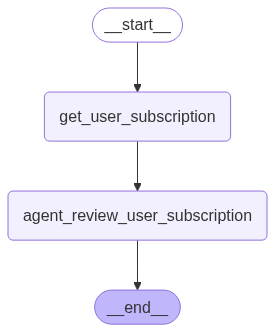

In [16]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(Image(agent.get_graph().draw_mermaid_png()))


## Testing Agent

In [26]:
question = "What is the most expensive subscriptions and their names that Bob is subscribed to and what is the name of that service?"
# for step in agent.stream(
#     {"messages": [{"role": "user", "content": question}], "user_id": 1},
#     stream_mode="messages",
# ):
#     # print(step)
#     step["messages"][-1].pretty_print()


result = agent.invoke({"messages": [{"role": "user", "content": question}], "user_id": 1})

print(result['messages'])
for messages in result['messages']:
    print(messages.content)


[HumanMessage(content='What is the most expensive subscriptions and their names that Bob is subscribed to and what is the name of that service?', additional_kwargs={}, response_metadata={}, id='63b4383b-e84d-4f08-80b7-007ec0680590'), AIMessage(content="Alice,\n\nBased on the provided subscription history, here's an analysis:\n\n1. **Usage Analysis**:\n   - Netflix: Canceled, so not actively used.\n   - Amazon Prime: Active, indicating current usage.\n   - Adobe Creative Cloud: Active, suggesting regular use.\n\n2. **Cost Efficiency Evaluation**:\n   - The most expensive subscription is Adobe Creative Cloud at $54.99. Its value depends on your need for professional design software. If you use it frequently for work or creative projects, it might be worthwhile. However, if usage is sporadic, it could be overpriced compared to alternatives.\n\n3. **Cheaper Alternatives**:\n   - For productivity and design, consider:\n     - **Google Workspace** (formerly G Suite): Offers similar apps like